In [149]:
import torch
from torch.utils import data
from mds189 import Mds189
import numpy as np
from skimage import io, transform
import ipdb
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import time

In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
# Helper functions for loading images.
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [161]:
# flag for whether you're training or not
is_train = True
is_key_frame = False # TODO: set this to false to train on the video frames, instead of the key frames
model_to_load = 'model_key.ckpt' # This is the model to load during testing, if you want to eval a previously-trained model.


In [162]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

In [163]:
# Parameters for data loader
params = {'batch_size': 25,  # TODO: fill in the batch size. often, these are things like 32,64,128,or 256
          'shuffle': True,
          'num_workers': 2 
          }
# TODO: Hyper-parameters
num_epochs = 25
learning_rate = 1e-4
# NOTE: depending on your optimizer, you may want to tune other hyperparameters as well

In [164]:
# Datasets
# TODO: put the path to your train, test, validation txt files
if is_key_frame:
    label_file_train =  './dataloader_files/keyframe_data_train.txt'
    label_file_val  =  './dataloader_files/keyframe_data_val.txt'
    # NOTE: the kaggle competition test data is only for the video frames, not the key frames
    # this is why we don't have an equivalent label_file_test with keyframes
else:
    label_file_train = './dataloader_files/videoframe_data_train.txt'
    label_file_val = './dataloader_files/videoframe_data_val.txt'
    label_file_test = './dataloader_files/videoframe_data_test.txt'

In [165]:
# TODO: you should normalize based on the average image in the training set. This shows 
# an example of doing normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
# TODO: if you want to pad or resize your images, you can put the parameters for that below.

In [170]:
# Generators
# NOTE: if you don't want to pad or resize your images, you should delete the Pad and Resize
# transforms from all three _dataset definitions.
train_dataset = Mds189(label_file_train,loader=default_loader,transform=transforms.Compose([
                                               transforms.Pad(padding=0),    # TODO: if you want to pad your images
                                               transforms.Resize((32, 32)), # TODO: if you want to resize your images
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
train_loader = data.DataLoader(train_dataset, **params)

val_dataset = Mds189(label_file_val,loader=default_loader,transform=transforms.Compose([
                                               transforms.Pad(padding=0),
                                               transforms.Resize((32, 32)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
val_loader = data.DataLoader(val_dataset, **params)

if not is_key_frame:
    test_dataset = Mds189(label_file_test,loader=default_loader,transform=transforms.Compose([
                                                   transforms.Pad(padding=0),
                                                   transforms.Resize((32, 32)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean, std)
                                               ]))
    test_loader = data.DataLoader(test_dataset, **params)

In [82]:
# TODO: one way of defining your model architecture is to fill in a class like NeuralNet()
# NOTE: you should not overwrite the models you try whose performance you're keeping track of.
#       one thing you could do is have many different model forward passes in class NeuralNet()
#       and then depending on which model you want to train/evaluate, you call that model's
#       forward pass. this strategy will save you a lot of time in the long run. the last thing
#       you want to do is have to recode the layer structure for a model (whose performance
#       you're reporting) because you forgot to e.g., compute the confusion matrix on its results
#       or visualize the error modes of your (best) model
# class NeuralNet(nn.Module):
#     def __init__(self):
#         super(NeuralNet, self).__init__()
#         # you can define some common layers, for example: 
#         self.conv1 = nn.Conv2d(3, 6, 5) # you should review the definition of nn.Conv2d online
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # note: input_dimensions and output_dimensions are not defined, they
#         # are placeholders to show you what arguments to pass to nn.Linear 
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 8)

#     def forward(self, x):
#         # now you can use the layers you defined, to write the forward pass, i.e.,
#         # network architecture for your model
#         x = self.pool(F.relu(self.conv1(x))) # x -> convolution -> ReLU -> max pooling
#         x = self.pool(F.relu(self.conv2(x)))
#         # Tensors need to be reshaped before going into an fc layer
#         # the -1 will correspond to the batch size
#         # x = x.view(-1, self.num_flat_features(x)) 
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x)) # x -> fc (affine) layer -> relu
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [167]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # x -> convolution -> ReLU -> max pooling
        x = x.view(-1, 6 * 14 * 14)
        x = F.relu(self.fc1(x)) # x -> fc (affine) layer -> relu
        x = self.fc2(x)
        return x

In [11]:
# class NeuralNet(nn.Module):
#     def __init__(self):
#         super(NeuralNet, self).__init__()
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(150, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 8)
        
#         self.fc4 = nn.Linear(3 * 32 * 32, 200)
#         self.fc5 = nn.Linear(200, 150)

#     def forward(self, x):
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [168]:
net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)


In [84]:
def check_val_loss(model):
    with torch.no_grad():
        loss = 0
        total = 0
        for (local_batch,local_labels) in val_loader:
            # Transfer to GPU
            local_ims, local_labels = local_batch.to(device), local_labels.to(device)
            outputs = model.forward(local_ims)
            loss += criterion(outputs, local_labels)
            total += 1
    return loss.item()/total

In [ ]:
start = time.time()
model = NeuralNet().to(device)
# if we're only testing, we don't want to train for any epochs, and we want to load a model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model_random_2.ckpt'))

# Loss and optimizer
criterion =  nn.CrossEntropyLoss() #TODO: define your loss here. hint: should just require calling a built-in pytorch layer.
# NOTE: you can use a different optimizer besides Adam, like RMSProp or SGD, if you'd like
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    # Training
    # print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels)
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        train_loss.append([total_step * epoch + i + 1, loss.item()])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, train_loss[-1][1]))
        
        if (i+1) % total_step == 0:
            val_loss.append([total_step * epoch + i + 1, check_val_loss(model)])
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, train_loss[-1][1], val_loss[-1][1]))

end = time.time()
print('Time: {}'.format(end - start))

Beginning training..
Epoch [1/25], Step [100/1509], Train Loss: 2.0426
Epoch [1/25], Step [200/1509], Train Loss: 1.9335
Epoch [1/25], Step [300/1509], Train Loss: 1.7958
Epoch [1/25], Step [400/1509], Train Loss: 2.1259
Epoch [1/25], Step [500/1509], Train Loss: 1.8402
Epoch [1/25], Step [600/1509], Train Loss: 1.8053
Epoch [1/25], Step [700/1509], Train Loss: 1.8023
Epoch [1/25], Step [800/1509], Train Loss: 1.8042
Epoch [1/25], Step [900/1509], Train Loss: 1.7450
Epoch [1/25], Step [1000/1509], Train Loss: 1.5357
Epoch [1/25], Step [1100/1509], Train Loss: 1.5113
Epoch [1/25], Step [1200/1509], Train Loss: 1.5766
Epoch [1/25], Step [1300/1509], Train Loss: 1.4827
Epoch [1/25], Step [1400/1509], Train Loss: 1.3276
Epoch [1/25], Step [1500/1509], Train Loss: 1.4500
Epoch [1/25], Step [1509/1509], Train Loss: 1.5033, Val Loss: 1.6347
Epoch [2/25], Step [100/1509], Train Loss: 1.3997
Epoch [2/25], Step [200/1509], Train Loss: 1.3909
Epoch [2/25], Step [300/1509], Train Loss: 1.4240
Epoc

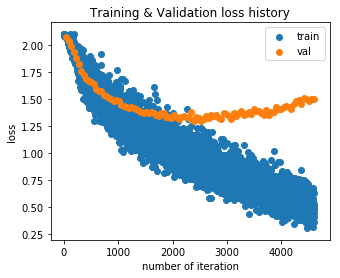

In [96]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.scatter(*zip(*train_loss))
plt.scatter(*zip(*val_loss))
plt.legend(['train', 'val'], loc='upper right')
plt.title('Training & Validation loss history')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.show()

In [62]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print(pytorch_total_params)

In [123]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Beginning Testing..')
with torch.no_grad():
    correct = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    counter = 0
    for (local_batch,local_labels) in val_loader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        predicted_list.extend(predicted)
        groundtruth_list.extend(local_labels)
#         if counter == 0:
#             print('i:', counter, '\n local_batch:', local_batch[0], '\n local_ims:', local_ims[0], 
#                   '\n local_labels:', local_labels[0], '\n predicted:', predicted[0], '\n outputs:', outputs[0])
#             print("\n")
#         counter = 1
        correct += (predicted == local_labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Beginning Testing..
i: 0 
 local_batch: tensor([[[ 0.4667,  0.4510,  0.4745,  ...,  0.6627,  0.6941,  0.7255],
         [ 0.4745,  0.4510,  0.4667,  ...,  0.6863,  0.7255,  0.7569],
         [ 0.4902,  0.4510,  0.4588,  ...,  0.7098,  0.7490,  0.7725],
         ...,
         [-0.4745, -0.4824, -0.4902,  ..., -0.2078, -0.1765, -0.1686],
         [-0.4824, -0.4902, -0.4588,  ..., -0.1765, -0.1451, -0.1451],
         [-0.4824, -0.4667, -0.4588,  ..., -0.1216, -0.1137, -0.1216]],

        [[ 0.4039,  0.4039,  0.4196,  ...,  0.6078,  0.6392,  0.6706],
         [ 0.4118,  0.4039,  0.4196,  ...,  0.6392,  0.6706,  0.7020],
         [ 0.4275,  0.4039,  0.4118,  ...,  0.6549,  0.6941,  0.7255],
         ...,
         [-0.4745, -0.4824, -0.4902,  ..., -0.2157, -0.1922, -0.1765],
         [-0.4824, -0.4824, -0.4667,  ..., -0.1843, -0.1686, -0.1608],
         [-0.4745, -0.4667, -0.4588,  ..., -0.1451, -0.1373, -0.1451]],

        [[ 0.2235,  0.2157,  0.2392,  ...,  0.4275,  0.4824,  0.5294],
     

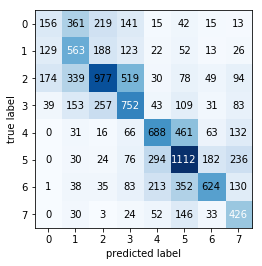

In [125]:
# Look at some things about the model results..
# convert the predicted_list and groundtruth_list Tensors to lists
pl = [p.cpu().numpy().tolist() for p in predicted_list]
gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

# TODO: use pl and gt to produce your confusion matrices
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_target=gt, 
                      y_predicted=pl, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [142]:
# view the per-movement accuracy
label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

# Save the model checkpoint
torch.save(model.state_dict(), 'model_1.ckpt')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


TypeError: zip argument #1 must support iteration

In [160]:
# TODO: you'll need to run the forward pass on the kaggle competition images, and save those results to a csv file.
import numpy as np
import pandas as pd

label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']

if not is_key_frame:
    # your code goes here!
    predicted_list = []
    with torch.no_grad():
        for (local_batch, _) in test_loader:
        # Transfer to GPU
            local_ims = local_batch.to(device)
            outputs = model.forward(local_ims)
            _, predicted = torch.max(outputs.data, 1)
            predicted_list.extend(predicted)
    
    pl = [p.cpu().numpy().tolist() for p in predicted_list]
    pl_to_text = np.array([label_map[i] for i in pl])
    csv_input = pd.read_csv('kaggle_submission_format-Copy1.csv')
    csv_input['Category'] = pl_to_text
    csv_input.to_csv('output.csv', index=False)
    

('./hw6_mds189/test_kaggle_frames/0000.jpg', './hw6_mds189/test_kaggle_frames/0001.jpg', './hw6_mds189/test_kaggle_frames/0002.jpg', './hw6_mds189/test_kaggle_frames/0003.jpg', './hw6_mds189/test_kaggle_frames/0004.jpg', './hw6_mds189/test_kaggle_frames/0005.jpg', './hw6_mds189/test_kaggle_frames/0006.jpg', './hw6_mds189/test_kaggle_frames/0007.jpg', './hw6_mds189/test_kaggle_frames/0008.jpg', './hw6_mds189/test_kaggle_frames/0009.jpg', './hw6_mds189/test_kaggle_frames/0010.jpg', './hw6_mds189/test_kaggle_frames/0011.jpg', './hw6_mds189/test_kaggle_frames/0012.jpg', './hw6_mds189/test_kaggle_frames/0013.jpg', './hw6_mds189/test_kaggle_frames/0014.jpg', './hw6_mds189/test_kaggle_frames/0015.jpg', './hw6_mds189/test_kaggle_frames/0016.jpg', './hw6_mds189/test_kaggle_frames/0017.jpg', './hw6_mds189/test_kaggle_frames/0018.jpg', './hw6_mds189/test_kaggle_frames/0019.jpg', './hw6_mds189/test_kaggle_frames/0020.jpg', './hw6_mds189/test_kaggle_frames/0021.jpg', './hw6_mds189/test_kaggle_frame